In [9]:
using Images
using PyPlot
using Test
using LinearAlgebra
using FileIO

# Transform from Cartesian to homogeneous coordinates
function cart2hom(points::Array{Float64,2})
  return [points; ones(1,size(points,2))]::Array{Float64,2}
end


# Transform from homogeneous to Cartesian coordinates
function hom2cart(points::Array{Float64,2})
  res = points[1:end-1,:] ./ points[end:end,:]
  return res::Array{Float64,2}
end


# Translation by v
function gettranslation(v::Array{Float64,1})
  T = Matrix{Float64}(I, 4, 4)
  T[1:3,4] = v
  return T::Array{Float64,2}
end


# Rotation of d degrees around x axis
function getxrotation(d::Int)
  r = deg2rad(d)
  Rx = Matrix{Float64}(I, 4, 4)
  Rx[2:3,2:3] = [cos(r) -sin(r); sin(r) cos(r)]
  return Rx::Array{Float64,2}
end


# Rotation of d degrees around y axis
function getyrotation(d::Int)
  r = deg2rad(d)
  Ry = Matrix{Float64}(I, 4, 4)
  Ry[[1 3],[1 3]] = [cos(r) sin(r); -sin(r) cos(r)]
  return Ry::Array{Float64,2}
end


# Rotation of d degrees around z axis
function getzrotation(d::Int)
  r = deg2rad(d)
  Rz = Matrix{Float64}(I, 4, 4)
  Rz[1:2,1:2] = [cos(r) -sin(r); sin(r) cos(r)]
  return Rz::Array{Float64,2}
end


# Central projection matrix (including camera intrinsics)
function getcentralprojection(principal::Array{Int,1}, focal::Int)
  return [focal 0.0 principal[1] 0.0;
          0.0 focal principal[2] 0.0;
          0.0 0.0 1.0 0.0]::Array{Float64,2}
end


# Return full projection matrix P and full model transformation matrix M
function getfullprojection(T::Array{Float64,2},Rx::Array{Float64,2},Ry::Array{Float64,2},Rz::Array{Float64,2},V::Array{Float64,2})
  M = Rz*Rx*Ry*T  # model transformations
  P = V*M         # full projection matrix
  return P::Array{Float64,2},M::Array{Float64,2}
end


# Load 2D points
function loadpoints()
  x = load("obj2d.jld2", "x")
  return x::Array{Float64,2}
end


# Load z-coordinates
function loadz()
  z = load("zs.jld2", "Z")
  return z::Array{Float64,2}
end


# Invert just the central projection P of 2d points *P2d* with z-coordinates *z*
function invertprojection(P::Array{Float64,2}, P2d::Array{Float64,2}, z::Array{Float64,2})
  K = P[:,1:3] # extract camera intrinsics
  P3d = z .* (K \ cart2hom(P2d)) # account for unknown scale
  return P3d::Array{Float64,2}
end


# Invert just the model transformation of the 3D points *P3d*
function inverttransformation(A::Array{Float64,2}, P3d::Array{Float64,2})
  X = A \ cart2hom(P3d)
  return X::Array{Float64,2}
end


# Plot 2D points
function displaypoints2d(points::Array{Float64,2})
  figure()
  plot(points[1,:],points[2,:],".b")
  xlabel("Screen X")
  ylabel("Screen Y")
 return nothing
end


# Plot 3D points
function displaypoints3d(points::Array{Float64,2})
  figure()
  scatter3D(points[1,:],points[2,:],points[3,:],".b")
  xlabel("World X")
  ylabel("World Y")
  zlabel("World Z")
  return nothing
end


# Apply full projection matrix *C* to 3D points *X*
function projectpoints(P::Array{Float64,2}, X::Array{Float64,2})
  return hom2cart(P*cart2hom(X))::Array{Float64,2}
end


#= Problem 2
Projective Transformation =#

#function problem3()
# parameters
t               = [6.7; -10; 4.2]
principal_point = [9; -7]
focal_length    = 8

# model transformations
T = gettranslation(t)
Ry = getyrotation(-45)
Rx = getxrotation(120)
Rz = getzrotation(-10)
display(T)
display(Ry)
display(Rx)
display(Rz)

4×4 Array{Float64,2}:
 1.0  0.0  0.0    6.7
 0.0  1.0  0.0  -10.0
 0.0  0.0  1.0    4.2
 0.0  0.0  0.0    1.0

4×4 Array{Float64,2}:
 0.707107  0.0  -0.707107  0.0
 0.0       1.0   0.0       0.0
 0.707107  0.0   0.707107  0.0
 0.0       0.0   0.0       1.0

4×4 Array{Float64,2}:
 1.0   0.0        0.0       0.0
 0.0  -0.5       -0.866025  0.0
 0.0   0.866025  -0.5       0.0
 0.0   0.0        0.0       1.0

4×4 Array{Float64,2}:
  0.984808  0.173648  0.0  0.0
 -0.173648  0.984808  0.0  0.0
  0.0       0.0       1.0  0.0
  0.0       0.0       0.0  1.0

In [6]:
# central projection including camera intrinsics
K = getcentralprojection(principal_point,focal_length)

3×4 Array{Float64,2}:
 8.0  0.0   9.0  0.0
 0.0  8.0  -7.0  0.0
 0.0  0.0   1.0  0.0

In [10]:
# full projection and model matrix
P,M = getfullprojection(T,Rx,Ry,Rz,K)
display(P)
display(M)

3×4 Array{Float64,2}:
  1.53823     7.09964   -9.60359   -101.025 
 -3.33198   -10.0014    -1.36738     71.9468
 -0.353553    0.866025  -0.353553   -12.514 

4×4 Array{Float64,2}:
  0.590027  -0.0868241  -0.802702    1.45007
 -0.725857  -0.492404   -0.480281   -1.95638
 -0.353553   0.866025   -0.353553  -12.514  
  0.0        0.0         0.0         1.0    

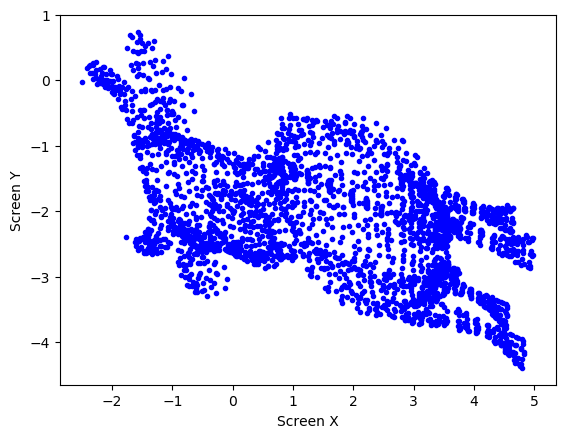

In [12]:
# load data and plot it
points = loadpoints()
displaypoints2d(points)

In [13]:
# reconstruct 3d scene
z = loadz()
Xt = invertprojection(K,points,z)

3×2904 Array{Float64,2}:
 -19.9886  -14.6504   -14.5222  -14.5277  …  -15.8693   -13.5451   -15.8991 
  14.0347    9.12794   10.3194   10.1833       9.01567    8.07884    8.86987
  20.0843   12.1105    11.3003   11.433       13.1298    13.706     12.7498 

In [14]:
Xh = inverttransformation(M,Xt)

4×2904 Array{Float64,2}:
 -35.7819  -26.2514   -26.7541   …  -27.2495    -25.4019   -27.0269  
  22.2183   17.2653    15.9659       18.3092     19.0677    18.0545  
  -1.9966   -1.10577   -1.49451      -0.433814   -2.05324   -0.205546
   1.0       1.0        1.0           1.0         1.0        1.0     

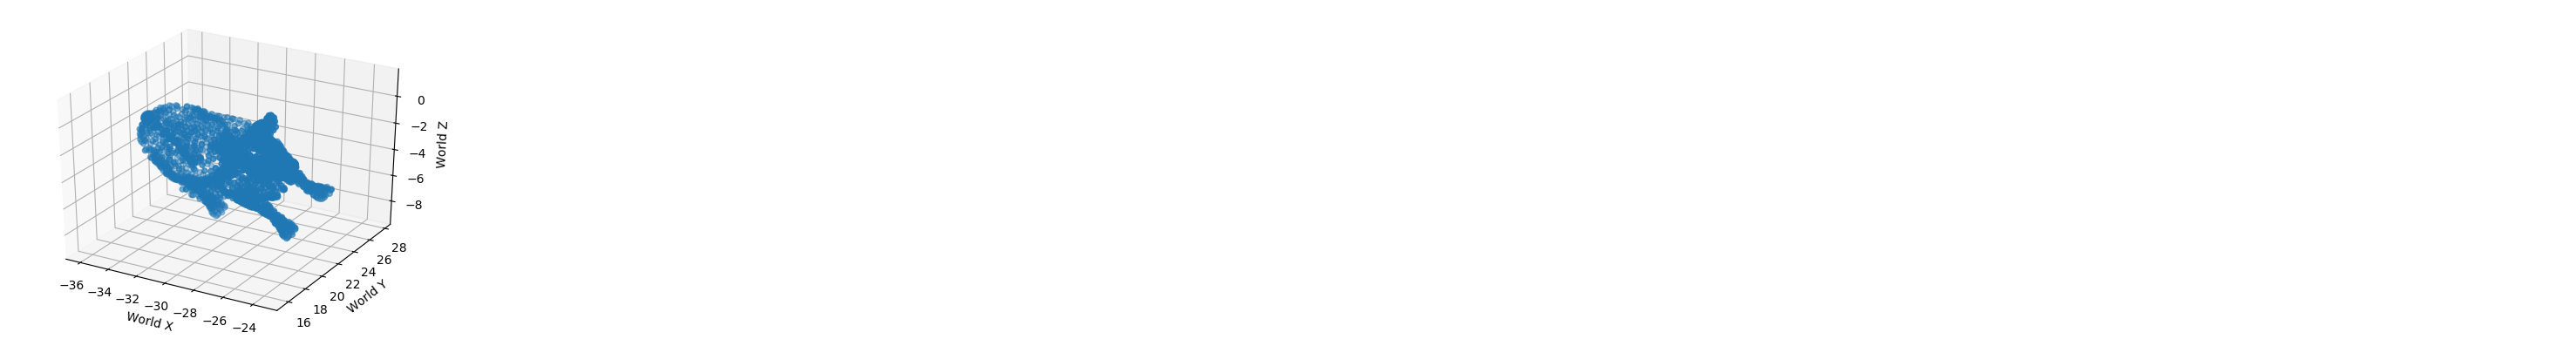

In [15]:
worldpoints = hom2cart(Xh)
displaypoints3d(worldpoints)

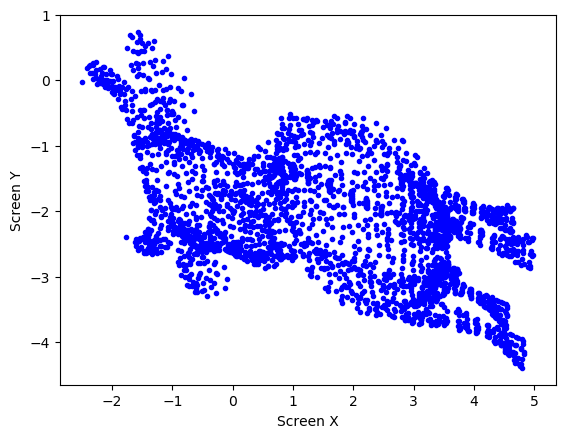

In [16]:
# reproject points
points2 = projectpoints(P,worldpoints)
displaypoints2d(points2)

In [17]:
# @test_approx_eq points points2
err = sum((points - points2).^2)

1.3311769882024034e-26